# Detección de impago en microcréditos

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
sns.set(style="whitegrid")

Cargar datos

In [2]:
# Cargar datos
df = pd.read_csv('microcreditos_knn.csv')
df.head()

,ingresos_mensuales,deuda_actual,historial_crediticio,edad,num_prestamos_previos,IMPAGO
0,1398.685661,771.183899,8,18,2,0
1,1144.694280,890.455398,1,20,1,0
2,1459.075415,500.607485,8,64,3,0
3,1809.211943,416.328980,6,43,5,0
4,1106.338650,274.454842,4,48,2,0


EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ingresos_mensuales     2500 non-null   float64
 1   deuda_actual           2500 non-null   float64
 2   historial_crediticio   2500 non-null   int64  
 3   edad                   2500 non-null   int64  
 4   num_prestamos_previos  2500 non-null   int64  
 5   IMPAGO                 2500 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 117.3 KB
Valores nulos:
 ingresos_mensuales       0
deuda_actual             0
historial_crediticio     0
edad                     0
num_prestamos_previos    0
IMPAGO                   0
dtype: int64
Distribución IMPAGO:
 IMPAGO
0    2255
1     245
Name: count, dtype: int64


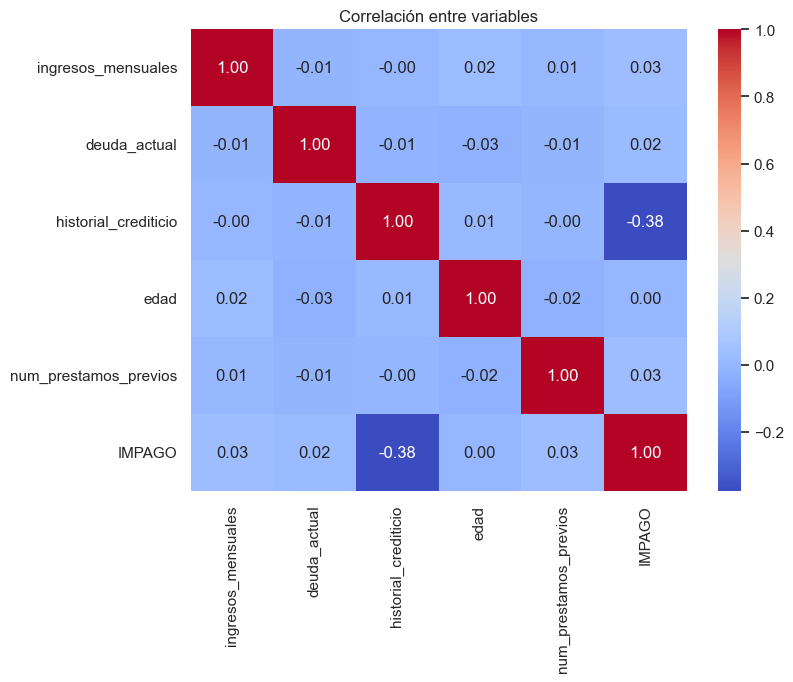

In [3]:
# EDA
df.info()
df.describe().T
print('Valores nulos:\n', df.isnull().sum())
print('Distribución IMPAGO:\n', df['IMPAGO'].value_counts())

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()

Separar variables

In [4]:
# Separar variables
X = df.drop('IMPAGO', axis=1)
y = df['IMPAGO']
X.head()

,ingresos_mensuales,deuda_actual,historial_crediticio,edad,num_prestamos_previos
0,1398.685661,771.183899,8,18,2
1,1144.694280,890.455398,1,20,1
2,1459.075415,500.607485,8,64,3
3,1809.211943,416.328980,6,43,5
4,1106.338650,274.454842,4,48,2


Escalar

In [5]:
# Escalar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,ingresos_mensuales,deuda_actual,historial_crediticio,edad,num_prestamos_previos
0,0.472196,0.591583,1.139213,-1.705515,-0.002847
1,-0.185482,0.995189,-1.527127,-1.571379,-0.714526
2,0.628568,-0.324026,1.139213,1.379618,0.708832
3,1.535202,-0.609217,0.377401,-0.028812,2.132190
4,-0.284799,-1.089308,-0.384410,0.306528,-0.002847


Train/Test split

In [6]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((1750, 5), (750, 5))

Modelo inicial

In [7]:
# Modelo inicial KNN (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Perfil de usuarios

In [8]:
# Perfil de usuarios por IMPAGO
display(df.groupby('IMPAGO').mean())
display(df.groupby('IMPAGO').size())

,ingresos_mensuales,deuda_actual,historial_crediticio,edad,num_prestamos_previos
IMPAGO,,,,,
0,1212.952695,594.732295,5.336142,43.418182,1.990687
1,1247.377508,611.361983,2.000000,43.534694,2.126531


IMPAGO
0    2255
1     245
dtype: int64

Evaluación

Accuracy: 0.8893


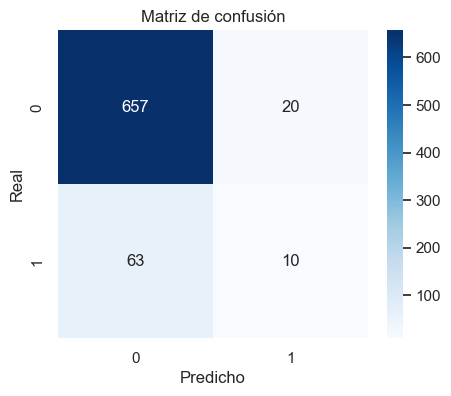

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       677
           1       0.33      0.14      0.19        73

    accuracy                           0.89       750
   macro avg       0.62      0.55      0.57       750
weighted avg       0.86      0.89      0.87       750

ROC AUC: 0.8011978713502357


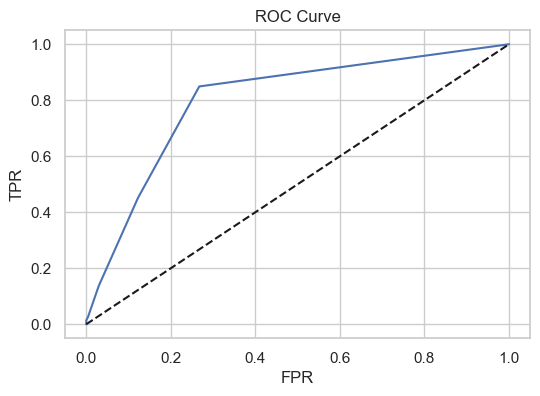

In [9]:
# Evaluación
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()
print(classification_report(y_test, y_pred))
if len(np.unique(y_test))==2:
    y_proba = knn.predict_proba(X_test)[:,1]
    print('ROC AUC:', roc_auc_score(y_test, y_proba))
    fpr,tpr,_ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

Elegir K óptimo

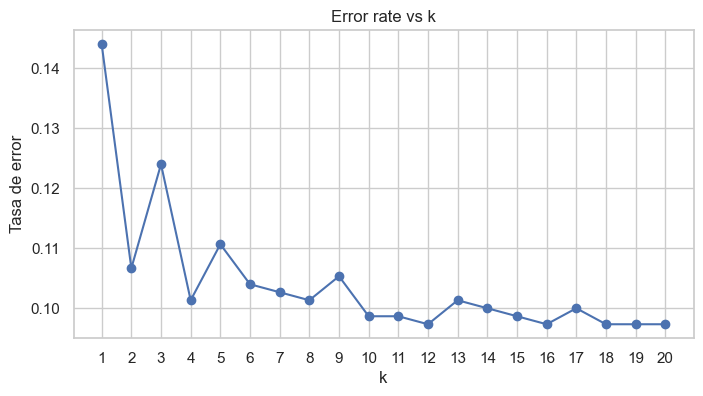

Mejor k por menor error: 12


In [10]:
# Elegir K óptimo (error rate)
error_rate = []
ks = range(1,21)
for k in ks:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    pred_k = knn_k.predict(X_test)
    error_rate.append(np.mean(pred_k != y_test))
plt.figure(figsize=(8,4))
plt.plot(ks, error_rate, marker='o')
plt.xlabel('k')
plt.ylabel('Tasa de error')
plt.title('Error rate vs k')
plt.xticks(ks)
plt.show()
best_k = ks[int(np.argmin(error_rate))]
print('Mejor k por menor error:', best_k)